In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# create a data generator
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
# load and iterate training dataset
train_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(224, 224),
    subset="training", 
    class_mode="sparse",
    batch_size=32)

val_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(224, 224), 
    subset="validation", 
    class_mode="sparse",
    batch_size=32)

Found 24006 images belonging to 11 classes.
Found 6000 images belonging to 11 classes.


In [3]:
IMAGE_SIZE = [224, 224]

In [4]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

2021-11-21 05:22:48.792763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-21 05:22:48.873660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1d:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-21 05:22:48.874485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:1e:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-21 05:22:48.874987: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-21 05:22:48.877511: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.

In [5]:
vgg.input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [6]:
for layer in vgg.layers:
  layer.trainable = False

In [7]:
x = Flatten()(vgg.output)
prediction = Dense(11, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [9]:
from datetime import datetime
start = datetime.now()

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='mymodel-rescale-data.h5', verbose=1, save_best_only=True)
callbacks = [checkpoint]

model_history = model.fit(
    train_it,
    validation_data=val_it,
    epochs=10,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10


2021-11-21 05:23:13.134421: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-21 05:23:14.893016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


751/751 [==============================] - ETA: 0s - loss: 2.1167 - accuracy: 0.3033
Epoch 00001: val_loss improved from inf to 2.28428, saving model to mymodel-rescale-data.h5
751/751 [==============================] - 1616s 2s/step - loss: 2.1167 - accuracy: 0.3033 - val_loss: 2.2843 - val_accuracy: 0.2247
Epoch 2/10
751/751 [==============================] - ETA: 0s - loss: 1.6369 - accuracy: 0.4407
Epoch 00002: val_loss did not improve from 2.28428
751/751 [==============================] - 1657s 2s/step - loss: 1.6369 - accuracy: 0.4407 - val_loss: 2.2875 - val_accuracy: 0.3140
Epoch 3/10
751/751 [==============================] - ETA: 0s - loss: 1.4477 - accuracy: 0.4947
Epoch 00003: val_loss did not improve from 2.28428
751/751 [==============================] - 1540s 2s/step - loss: 1.4477 - accuracy: 0.4947 - val_loss: 2.4103 - val_accuracy: 0.3043
Epoch 4/10
751/751 [==============================] - ETA: 0s - loss: 1.3647 - accuracy: 0.5279
Epoch 00004: val_loss did not impr

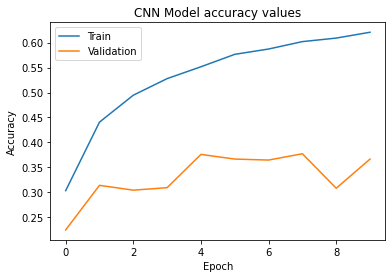

In [10]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

In [11]:
model.save('mymodel-rescale-data-end.h5')